## Eye for Blind - Image Captioning using Attention Mechanism

WHO estimates show that there are approximately 285 million visually impaired people worldwide, out of which 39 million are completely blind. It is extremely difficult for them to carry out many daily activities, one of which is reading - from reading a newspaper / magazine to an important text message from your bank. 

Converting an image to text can be viewed as two sub tasks - 1. Generating cpations describing the image 2. Text to Speech Conversion.

A custom Deep Learning Model is built using Tensorflow and Keras based on Encoder - Decoder architecture with Bahdanau Attention Mechanism. The Model has been trained and tested on Flickr8k dataset. ImageNet, a CNN model pre-trained for image classification, is used for feature extraction. These features are passed through an RNN , which generates a caption , with due regard to previously generated words. This model improves the standard encoder-decoder architecture by the addition of an attention mechanism which helps the network focus on a part of the image (instead of focusing on the entire image all the time ) based on the words previously generated. The generated caption is ranked based on Greedy Search and evaluated using the Bilingual Evaluation Understudy ( BLEU ) score. Neural Architecture in this project is based on Show, Attend & Tell,2015.

Libraries : Keras, Tensorflow
Concepts : Feature Extraction using ImageNet, GRU, Bahdanau Attention Mechanism, Greedy Search, Blue Score


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
#Import all required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import glob
import time
import json
import string
from collections import Counter
from tqdm import tqdm

import tensorflow as tf
tf.random.set_seed(89)
import keras
from keras import backend


2022-12-16 17:56:00.766968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 17:56:00.908389: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-16 17:56:01.595240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [11]:
import random
random.seed(89)

### **Text(Captions) Processing**

1.   Loading Data & Create Dataframe for Images & Captions
2.   Word to Index Mapping  
3.   Convert Sentence to word token indexes
4.   Padding each caption to the Max length of caption

##### **Loading Data & Create Dataframe for Images & Captions**

In [12]:
# Loading Images 
data_folder = '/home/Eye for Blind/data'
imgs = glob.glob(f'{data_folder}/Images/' + '*.jpg', recursive=True)
print("Number of Images:{}".format(len(imgs)))

Number of Images:8091


In [13]:
# Loading Captions
df_image_captions = pd.read_csv(f'{data_folder}/captions.txt')
df_image_captions.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [14]:
df_image_captions.shape

(40455, 2)

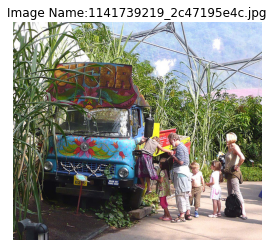

Img Shape (437, 500, 3) 

Captions for  1141739219_2c47195e4c.jpg -
['A family gathered at a painted van'
 'A girl climbing down from the side of a bright blue truck while others watch .'
 'A man is helping a girl step down from a colorful truck whilst a woman and three children watch .'
 'A very colorful bus is pulled off to the side of the road as its passengers load .'
 'Two women and four children standing next to a brightly painted truck .'] 



In [15]:
# Let's visualise how Image and its Caption lok like
random_index = random.randint(0,len(imgs))
img_name = df_image_captions.loc[random_index,'image']
img = plt.imread(data_folder +'/Images/' + img_name)
plt.title('Image Name:'+ img_name)
plt.imshow(img)
plt.axis('off')
plt.show()
print('Img Shape', img.shape, '\n')

print('Captions for ', img_name, '-')
print(df_image_captions.loc[df_image_captions['image'] == img_name, 'caption'].values, '\n')

In [16]:
# Create Dataframe for model building purpose
img_ids = df_image_captions['image'].values
img_paths =(data_folder+'/Images/'+ df_image_captions['image']).values
captions =df_image_captions['caption'].values

df = pd.DataFrame(zip(img_ids, img_paths, captions), columns = ['Id','Path','Caption'])
df.head()

,Id,Path,Caption
0,1000268201_693b08cb0e.jpg,/home/Eye for Blind/data/Images/1000268201_693...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/home/Eye for Blind/data/Images/1000268201_693...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/home/Eye for Blind/data/Images/1000268201_693...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/home/Eye for Blind/data/Images/1000268201_693...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/home/Eye for Blind/data/Images/1000268201_693...,A little girl in a pink dress going into a woo...


##### **Word to Index Mapping**

In [17]:
# First Remove all punctuations
df['Caption']  = df['Caption'].apply(lambda x : ''.join(e for e in x if e not in string.punctuation))
vocab = [ y for x in df['Caption'].values for y in x.split()]
word_index = Counter(vocab)
word_index.most_common(15)

[('a', 40319),
 ('A', 22667),
 ('in', 18962),
 ('the', 15328),
 ('on', 10730),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7984),
 ('with', 7760),
 ('man', 6829),
 ('of', 6712),
 ('Two', 4365),
 ('white', 3876),
 ('black', 3696),
 ('are', 3503)]

In [18]:
#Visualise the top 30 occuring words in the captions
def plot_top_words(words_counter):
    words= []
    counts=[]
    for word_counter in words_counter:
      words.append(word_counter[0])
      counts.append(word_counter[1])
    plt.figure(figsize=(20,10))
    plt.title('Top 30 Occuring Words')
    plt.xlabel('Word')
    plt.ylabel('Freq')
    plt.xticks(rotation='45')
    plot = sns.barplot(x=words,y=counts)
    for p in plot.patches:
      plot.annotate(format(int(p.get_height())),
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='center',
                    xytext=(0,9),
                    textcoords = 'offset points'
                    )
    plt.show()

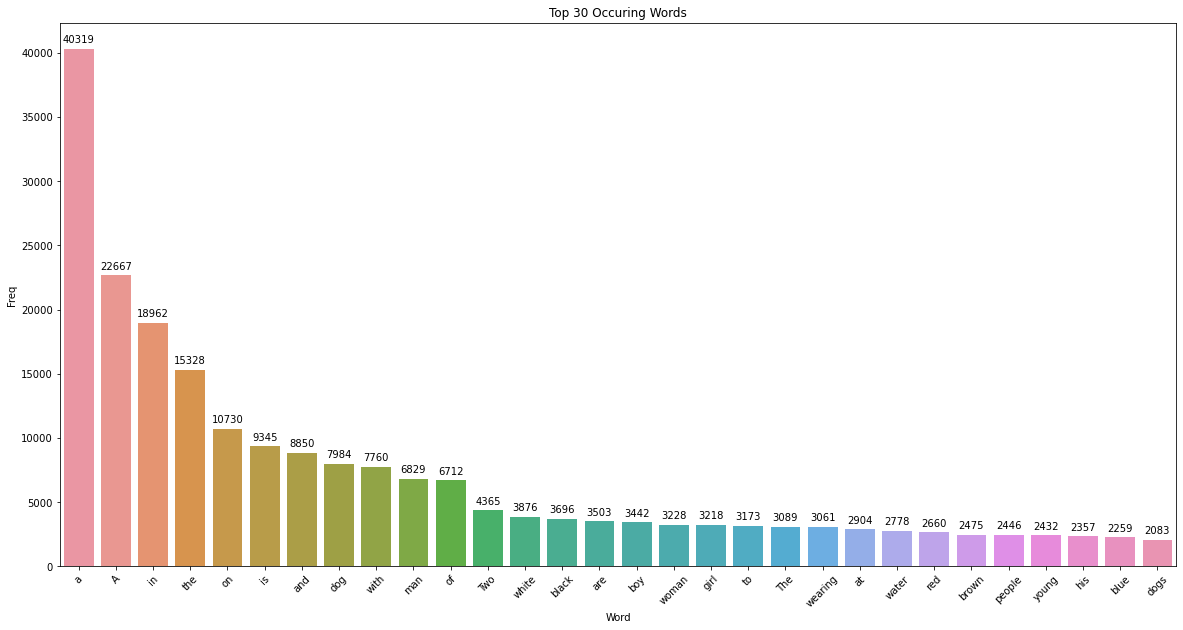

In [19]:
plot_top_words(word_index.most_common(30))

In [20]:
# Adding <start> and <end> token to each caption
captions_with_tokens = (df['Caption'].apply(lambda x : '<start> ' + x + ' <end>')).values

In [21]:
captions_with_tokens

array(['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
       '<start> A girl going into a wooden building  <end>',
       '<start> A little girl climbing into a wooden playhouse  <end>',
       ...,
       '<start> A person in a red shirt climbing up a rock face covered in assist handles  <end>',
       '<start> A rock climber in a red shirt  <end>',
       '<start> A rock climber practices on a rock climbing wall  <end>'],
      dtype=object)

In [22]:
#Creating a list which contains all the path to the images
imgs_path= df['Path'].to_list()

##### **Convert Sentence to word token indexes**

In [23]:
# Create Tokeniser
filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '  # Removed < and >
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = 5000,
    filters = filter_chars,
    lower = True,
    char_level=False,
    oov_token='<unk>'
)

tokenizer.fit_on_texts(captions_with_tokens)

captions_with_indexes = tokenizer.texts_to_sequences(captions_with_tokens)
captions_with_indexes[:5]

[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4]]

In [24]:
# Create word2index and index2word mapping
word2index_dict = json.loads(tokenizer.get_config()['word_index'])
index2word_dict = json.loads(tokenizer.get_config()['index_word'])

##### **Padding each caption to the Max length of caption**

In [25]:
max_length_caption = max([len(caption) for caption in captions_with_indexes])
print("Max length of caption is: {}".format(max_length_caption))

Max length of caption is: 38


In [26]:
#Padding to max_length_caption
captions_with_indexes_n_padding = tf.keras.preprocessing.sequence.pad_sequences(
    captions_with_indexes, padding='post'
)

print("Captions shape after padding : ", captions_with_indexes_n_padding.shape )

Captions shape after padding :  (40455, 38)


In [27]:
#Adding padding index to our tokenizer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

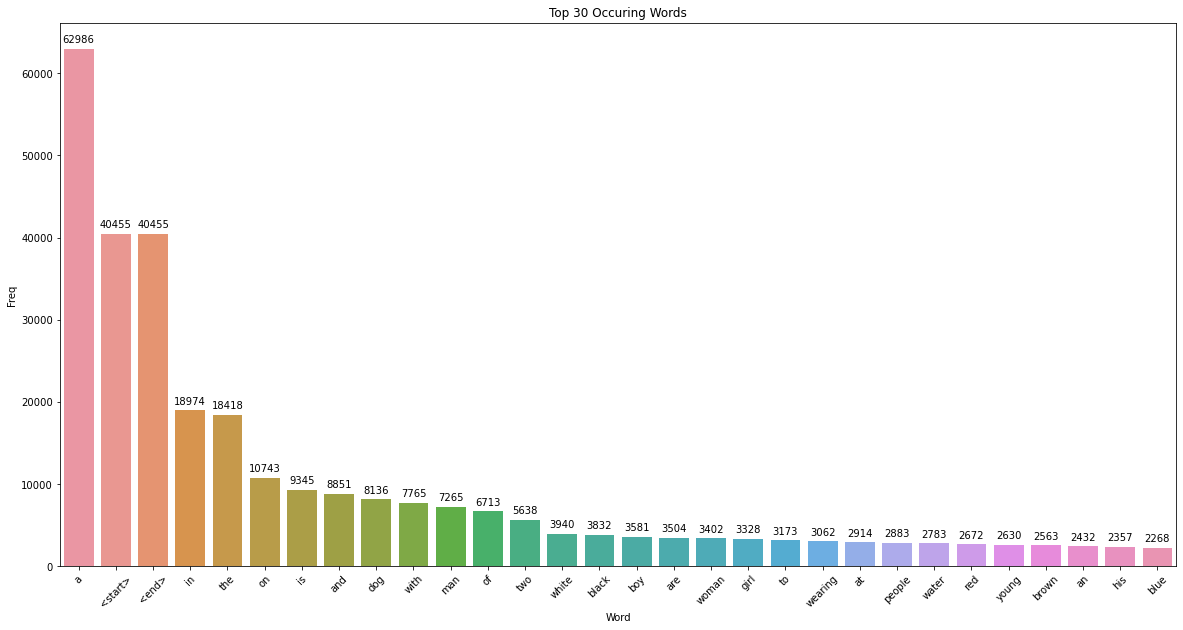

In [28]:
# Visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda x : x[1], reverse= True)
plot_top_words(sort_word_by_count[:30])

In [29]:
## Save Tokenizer
# import pickle

# with open('/home/Eye for Blind/checkpoint/tokenizer.pkl',"wb") as f:
#     pickle.dump(tokenizer,f)

### **Image Processing**
1.  Resize them into the shape of (299, 299)

2.   Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.



In [30]:
# Resizing and Normalising 
def preprocess_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img) #Normalize the image within the range of -1 to 1
    return img, img_path

In [31]:
# Check the preprocessing Logic
print(f'Size of image before preprocessing: {plt.imread(imgs_path[0]).shape}')
print(f'Size of image after preprocessing: {preprocess_img(imgs_path[0])[0].shape}')

Size of image before preprocessing: (500, 375, 3)
Size of image after preprocessing: (299, 299, 3)


2022-12-16 17:56:21.194014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 17:56:21.912983: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-16 17:56:21.913021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14780 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


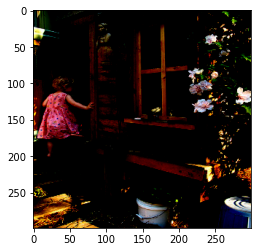

In [32]:
plt.imshow(preprocess_img(imgs_path[0])[0])

In [33]:
# Inceptionv3 Model with ImageNet weights
def load_inception_model():
    img_model =tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = img_model.input
    new_output = img_model.layers[-1].output
    return tf.keras.Model(new_input,new_output)

In [34]:
load_inception_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [35]:
img_features_extract_model = load_inception_model()

In [36]:
# Creating an tf.dataset with unique images in the dataset
unique_imgs = sorted(set(imgs_path))
img_dataset = tf.data.Dataset.from_tensor_slices(unique_imgs)
img_dataset = img_dataset.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [37]:
img_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [38]:
# Saving extracted features of img
from tqdm import tqdm
for img, path in tqdm(img_dataset):
    features = img_features_extract_model(img)
    features = tf.reshape(features,
                              (features.shape[0], -1, features.shape[3]))
    for bf, p in zip(features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 253/253 [00:55<00:00,  4.54it/s]


### **Model Building**

1.   Create Train & Test Data
2.   Build Model 
3.   Model Training & Optimization
4.   Model Evaluation

##### **Create Train & Test Data**
Shape of I/p  img - (batch_size,299,299,3)

Shape of I/p caption - (batch_size, max_length_caption)

In [39]:
img_path_train, img_path_test, cap_train, cap_test = train_test_split(
    imgs_path,
    captions_with_indexes_n_padding,
    test_size=0.2,
    random_state=89)

In [40]:
print("Training data for images: " + str(len(img_path_train)))
print("Testing data for images: " + str(len(img_path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [41]:
#Take Path of img and return features'path for that img along with caption

def map_function(img_name,capt):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy') # write your code here to extract the features from the dictionary stored earlier
    return img_tensor,capt

In [42]:
# Create tf Dataset- Computationally effective by parellel processing and prefetching of data
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def generate_dataset(img_path, caption):
    data = tf.data.Dataset.from_tensor_slices((img_path,caption))
    data = data.shuffle(BUFFER_SIZE)

  # Map img_path to feature generated from InceptionV3
    data = data.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle & Prefetch
    data = data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return data

In [43]:
train_data = generate_dataset(img_path_train, cap_train)
test_data = generate_dataset(img_path_test, cap_test)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [44]:
# train_data_size for batch
sample_train_img_batch, sample_train_cap_batch = next(iter(train_data))
print(sample_train_img_batch.shape)  # (batch_size, 8*8, 2048)
print(sample_train_cap_batch.shape)  # (batch_size, max_length of sequence)

(64, 64, 2048)
(64, 38)


##### **Build Model**
Encode & Decoder with Attention Mechanism

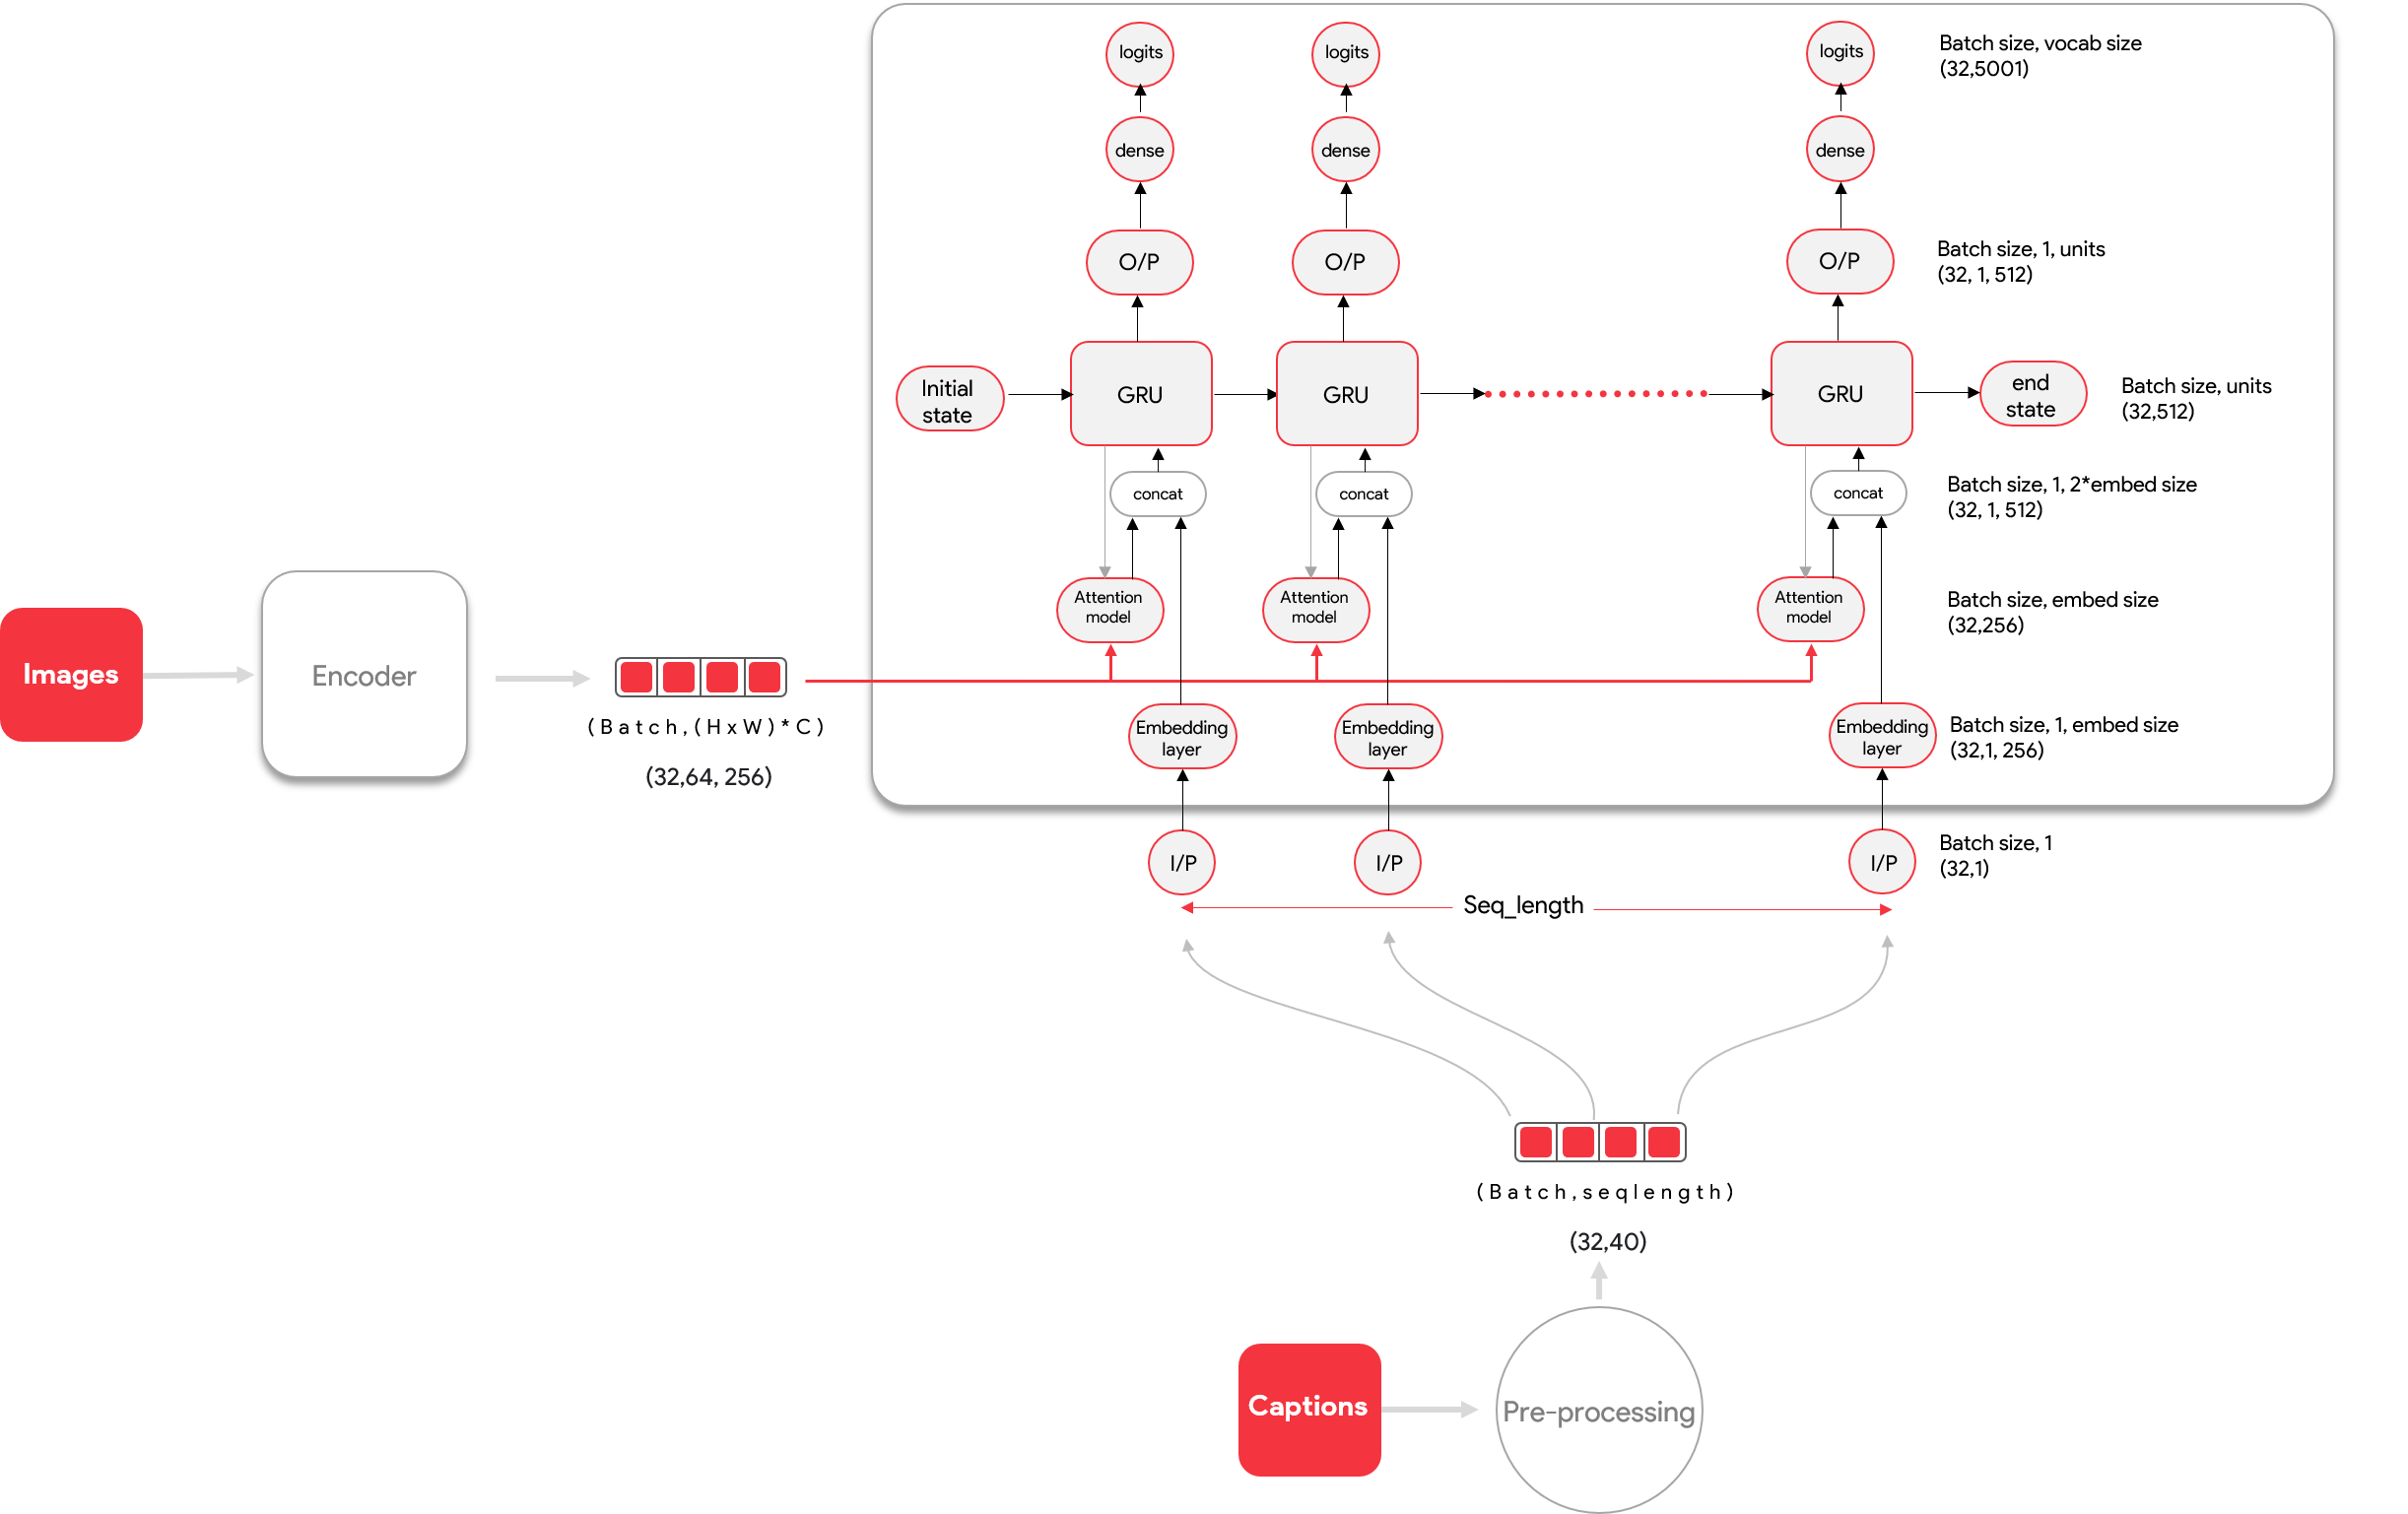

In [45]:
embed_dims = 256
units = 512
vocab_size = 5001 # top 5000 + 1 for <unk>
train_num_steps = len(img_path_train) // BATCH_SIZE
test_num_steps = len(img_path_test) // BATCH_SIZE

In [46]:
train_num_steps

505

###### **Encoder**
CNN based encoder using keras subclassing

In [47]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dims=256):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dims, activation='relu') # Shape of feature :(64,2048) --> (64,256) to concatenate with embedded vector for word of caption
    
    def call(self,features):
        features = self.dense(features)
        return features

In [48]:
encoder = Encoder(embed_dims)

###### **Attention**

In [49]:
class Attention(tf.keras.Model):
    def __init__(self,units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #Dense layer for linear transforming encoder features: (64,256)-->(64,512)
        self.W2 = tf.keras.layers.Dense(units) #Dense layer for linear transforming embedded vector of word : (1,256)-->(1,512)
        self.V = tf.keras.layers.Dense(1) #Dense layer with unit 1 for input of tanh(W1 + W2)
        self.units = units

    def call(self,features,hidden_state):
        # features shape - (batch_size, 64, embed_dims), hidden_state shape - (batch_size, units=512)
        hidden_with_time_axis = tf.expand_dims(hidden_state,1) # (batch_size, 1, units=512)
        #When adding two input values of different shapes, "Add" follows NumPy broadcasting rules
        attention_hidden_layer = tf.keras.activations.tanh( self.W1(features) + self.W2(hidden_with_time_axis) ) # (batch_size, 64,units=512 ) + (batch_size, 1, units=512) --> (batch_size, 64, units=512) --> Ex. A = [1,2,3,4,5], B = [1], A+ B = [2,3,4,5,6]
        score = self.V(attention_hidden_layer) # (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(score, axis=1) # attention_weights shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features # context_vector shape - (batch_size, 8*8, embed_dims)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # Reduce shape to (batch_size, embed_dims)
       
        return context_vector, attention_weights

###### **Decoder**
RNN based decoder

**GRU output and hidden state**

input_1 = tf.random.normal([32, 10, 8])

gru_1 = tf.keras.layers.GRU(4, return_sequences=True, return_state=True)

whole_sequence_output, final_state = gru(inputs)

print(whole_sequence_output.shape) ==> (32,10,4)

print(final_state.shape) ==> (32,4)

In [50]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dims, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attention(self.units) #iniitalizing Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dims) #building an Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #Dense layer
        
    def call(self, x, features, hidden_state):
        # context_vector shape - (batch_size, embed_dims), attention_weights shape - (batch_size, 8*8, 1)
        context_vector, attention_weights = self.attention(features, hidden_state)
        embed = self.embed(x) # (batch_size, 1) --> (batch_size,1, embed_dims)
        concated_input = tf.concat([tf.expand_dims(context_vector,1), embed], axis=-1) # (batch_size, 1, embed_dims+embed_dims )
        output, hidden_state = self.gru(concated_input) # Output Shape - (batch_size, max_length_caption, units=512)  as we have set return_sequences=True, hidden_state shape - (batch_size, units=512) that's why we expand dimn to (batch_size, 1 , units=512) in attention model
        output = self.d1(output)
        output = tf.reshape(output,(-1,output.shape[2]))   # o/p shape- (batch_size*max_length_caption, units=512)
        output = self.d2(output) # o/p shape- (batch_size*max_length_caption, vocab_size=5001)
        
        return output, hidden_state, attention_weights


    def init_state(self,batch_size):
        return tf.zeros((batch_size, self.units)) 
    

In [51]:
#Decoder process for single word
#(64, 1) dec_input shape before embedding
#(64, 1, 256) dec_input after embdedding

#(64, 256) context_vector shape from attention
#(64,1,256) context_vector after expand_dims

#(64, 1, 512) concated_input shape

#This is repeated for all words in sequnce and this gives output of (64,max_caption_length, 512) at GRU, 
#with (64,512) hidden_state shape at every time step and we then expand hidden_state to (64,1,512) to pass with 
# (64,64,256) extracted feature vector into Attention

In [52]:
decoder = Decoder(embed_dims, units, vocab_size)

In [53]:
features = encoder(sample_train_img_batch)
hidden = decoder.init_state(batch_size= sample_train_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_train_cap_batch.shape[0], 1)
predictions, hidden_state, attention_weights = decoder(dec_input, features, hidden)
print("dec_input shape : {}".format(dec_input.shape))
print("Feature shape from Encoder : {}".format(features.shape))
print("Predictions shape from Decoder : {}".format(predictions.shape))
print("hidden_state shape from Encoder : {}".format(hidden_state.shape))
print("Attention weights shape from Decoder : {}".format(attention_weights.shape)) 

dec_input shape : (64, 1)
Feature shape from Encoder : (64, 64, 256)
Predictions shape from Decoder : (64, 5001)
hidden_state shape from Encoder : (64, 512)
Attention weights shape from Decoder : (64, 64, 1)


##### **Model Training & Optimization**
We will apply teacher forcing during training of the model.

Teacher forcing is a technique where actual word is passed as input to decoder instead of previous prediction 

**Categorical cross entropy** is represented as

$J(\textbf{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \text{log}(\hat{y}_i) + (1-y_i) \text{log}(1-\hat{y}_i) \right]$


> If our Yi's are one-hot encoded, we use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0], [0,1,0], [0,0,1]

> But if our Yi's are integers, we use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1], [2], [3]

> As actual target variable is having word(i.e.class) index, we use SCCE

**Ex**

`actual seq = [1,12,120,131,0,0]]`    --> here 1,12,120 = word index in vocab & 0 is padding

`pred seq shape (6,5001)`    --> 5000 vocab and 1 for padding

In [54]:
# Optmizer and loss object
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none' ) # Gives loss for every word

In [55]:
def loss_function(actual, pred):
    # actual = [1,12,120,131,0,0] & pred = []
    # tf.math.equal(actual,0) = [false,false,false,false, true, true]
    # mask = tf.math.logical_not(tf.math.equal(actual,0)) = [true,true,true,true, false, false]
    # loss = [1,2,3,4,5,6]
    mask = tf.math.logical_not(tf.math.equal(actual,0)) # masking padding sequnces
    loss_ = loss_object(actual, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)  # avg loss across batch

In [56]:
# Checkpoint 
checkpoint_path = "/home/Eye for Blind/checkpoint/train/"
ckpt = tf.train.Checkpoint(encoder= encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [57]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) # retrieve last epoch from saved checkpoints
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [58]:
# img_tensor shape - (batch_size, 8*8, 2048) &  target shape - (batch_size, max_len)

@tf.function
def train_step(img_tensor, target):
    loss = 0
    # First time stamp :  hidden_state will be initialized to zeros
    hidden = decoder.init_state(batch_size=target.shape[0])
    # First time stamp : <start> token will be input to decoder and the same need to be reshaped 
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            # Set decoder_input - actual word at previous time stamp (i.e. teacher forcing) so decoder_input = target[:,i]
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [59]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)  # shape (batch_size,1)

    with tf.GradientTape() as tape:
    #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            predicted_id = tf.argmax(predictions,1)
            # Set decoder_input - previous predicted word not actual one
            dec_input = tf.expand_dims(predicted_id, 1)

    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [60]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_data):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    return total_loss/test_num_steps

###### **Now Training for all train dataset**

In [71]:
import time
train_loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=5
for epoch in tqdm(range(EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_data):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    train_loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_data)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.602, & test loss is 2.103
Time taken for 1 epoch 144.56214094161987 sec

Test loss has been reduced from 5.000 to 2.103


 13%|█▎        | 2/15 [03:30<21:20, 98.49s/it] 

For epoch: 2, the train loss is 0.574, & test loss is 2.173
Time taken for 1 epoch 66.08298826217651 sec



 20%|██        | 3/15 [04:36<16:41, 83.47s/it]

For epoch: 3, the train loss is 0.546, & test loss is 2.270
Time taken for 1 epoch 65.59442377090454 sec



 27%|██▋       | 4/15 [05:42<14:02, 76.62s/it]

For epoch: 4, the train loss is 0.520, & test loss is 2.287
Time taken for 1 epoch 66.12872815132141 sec



 33%|███▎      | 5/15 [06:49<12:09, 72.96s/it]

For epoch: 5, the train loss is 0.493, & test loss is 2.360
Time taken for 1 epoch 66.46336531639099 sec



 40%|████      | 6/15 [07:54<10:34, 70.50s/it]

For epoch: 6, the train loss is 0.469, & test loss is 2.405
Time taken for 1 epoch 65.7247405052185 sec



 47%|████▋     | 7/15 [09:00<09:12, 69.00s/it]

For epoch: 7, the train loss is 0.449, & test loss is 2.491
Time taken for 1 epoch 65.91181063652039 sec



 53%|█████▎    | 8/15 [10:07<07:58, 68.40s/it]

For epoch: 8, the train loss is 0.428, & test loss is 2.600
Time taken for 1 epoch 67.10274314880371 sec



 60%|██████    | 9/15 [11:14<06:46, 67.81s/it]

For epoch: 9, the train loss is 0.410, & test loss is 2.687
Time taken for 1 epoch 66.50417017936707 sec



 67%|██████▋   | 10/15 [12:20<05:35, 67.17s/it]

For epoch: 10, the train loss is 0.392, & test loss is 2.772
Time taken for 1 epoch 65.75059580802917 sec



 73%|███████▎  | 11/15 [13:26<04:27, 66.96s/it]

For epoch: 11, the train loss is 0.376, & test loss is 2.832
Time taken for 1 epoch 66.47015857696533 sec



 80%|████████  | 12/15 [14:32<03:19, 66.58s/it]

For epoch: 12, the train loss is 0.365, & test loss is 2.928
Time taken for 1 epoch 65.72188115119934 sec



 87%|████████▋ | 13/15 [15:38<02:12, 66.33s/it]

For epoch: 13, the train loss is 0.347, & test loss is 2.976
Time taken for 1 epoch 65.73857688903809 sec



 93%|█████████▎| 14/15 [16:43<01:06, 66.22s/it]

For epoch: 14, the train loss is 0.334, & test loss is 3.081
Time taken for 1 epoch 65.98034167289734 sec



100%|██████████| 15/15 [17:50<00:00, 71.36s/it]

For epoch: 15, the train loss is 0.326, & test loss is 3.130
Time taken for 1 epoch 66.44508004188538 sec



###### **Loss Curve**

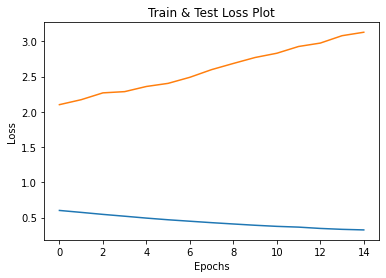

In [72]:
plt.plot(train_loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss Plot')
plt.show()

##### **Model Evaluation**
1.Evaluation using greedy search

2.Evaluation using beam search

3.Test it on a sample data using BLEU score

###### **Greedy Search**

In [102]:
attention_ip_features_shape = 64

def greedy_search_evaluate(img_path):
    preprocessed_img = tf.expand_dims(preprocess_img(img_path)[0],0) # preprocessed_img shape = (1,1,1,3)
    extracted_features = img_features_extract_model(preprocessed_img) # Extracted features Shape = (1,8,8,2048)
    reshaped_features = tf.reshape(extracted_features,(extracted_features.shape[0],-1, extracted_features.shape[3])) # Reshaped features Shape = (1,64,2048)
   
    encoded_features = encoder(reshaped_features) # Shape =(1,64,256) --> 256=embed_dims

    decoder_ip = tf.expand_dims([tokenizer.word_index['<start>']], 1) #shape =(1,1)
    print("decoder_ip Shape", decoder_ip.shape)
    hidden_state = decoder.init_state(batch_size=1) #shape=(1,512) --> 512 = units
    pred_words = []
    attention_plot = np.zeros((max_length_caption, attention_ip_features_shape))
  
    for i in range(max_length_caption):
        predictions, hidden_state, attention_weights = decoder(decoder_ip,encoded_features,hidden_state) # predictions = (1,5001), attention_weights = (1,64)
        attention_plot[i] = tf.reshape(attention_weights,(-1, )).numpy()
        # predicted_id = tf.argmax(predictions)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        word = tokenizer.index_word[predicted_id]
        pred_words.append(word)

        if word =='<end>':
            pred_caption = ' '.join(pred_words).rsplit(' ', 1)[0]
            return pred_caption, attention_plot, predictions
        decoder_ip =  tf.expand_dims([predicted_id], 0)

    attention_plot = predictions[:len(pred_words), :]

    return pred_caption, attention_plot, predictions

###### **Beam Search**

In [103]:
def beam_search_evaluate(img_path, beam_index=3):
    preprocessed_img = tf.expand_dims(preprocess_img(img_path)[0],0) # preprocessed_img shape
    extracted_features = img_features_extract_model(preprocessed_img) # Extracted features Shape = (1,8,8,2048)
    reshaped_features = tf.reshape(extracted_features,(extracted_features.shape[0],-1,tf.shape(extracted_features)[3])) # Reshaped features Shape = (1,64,2048)
    encoded_features = encoder(reshaped_features) # Shape =(1,64,256) --> 256=embed_dims

    decoder_ip = tf.expand_dims([tokenizer.word_index['<start>']], 1) #shape =(1,1)
    hidden_state = decoder.init_state(batch_size=1) #shape=(1,512) --> 512 = units
    attention_plot = np.zeros((max_length_caption, attention_ip_features_shape))

    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]] # 0.0 -- prob for start sequence, here start is seq of words, but initially it is having one word <start>
 
  # we keep going till our start contains all words in sequence
    while len(result[0][0]) < max_length_caption:
        temp = [] #For appending start
        for i, s in enumerate(result):
            predictions, hidden_state, attention_weights = decoder(decoder_ip,encoded_features,hidden_state) # predictions = (1,5001), attention_weights = (1,64)
            attention_plot[i] = tf.reshape(attention_weights,(-1, )).numpy()
            high_prob_words_index = np.argsort(predictions[0])[-beam_index:] # Gives 3 index of predictions which has highest prob value in ascending order
            # Ex - high_prob_words_index = [100,32,304] 
            for word_index in high_prob_words_index:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(word_index)
                prob += np.log(predictions[0][word_index]) # log prob for predicted value
                temp.append([next_cap, prob])  # next_cap is sequence of words and prob is probability for that seq
        result = temp
        result = sorted(result, reverse=False, key=lambda elem: elem[1])
        result = result[-beam_index:]

        predicted_id = result[-1]
        pred_list_with_id= predicted_id[0]
        pred_list_last_id = pred_list_with_id[-1]

        # If last word is not <end> then
        if pred_list_last_id != 3: 
            decoder_ip =  tf.expand_dims([pred_list_last_id], 0)
        else:
            break

    pred_list_with_id2 = result[-1][0]
    pred_list_with_words = [tokenizer.index_word[i] for i in pred_list_with_id2]
    pred_caption = []
    for i in pred_list_with_words:
        if i != '<end>':
            pred_caption.append(i)
        else:
            break
    pred_caption = ' '.join(pred_caption[1:]) # leaving <start> token
    return pred_caption

###### **Test image**

decoder_ip Shape (1, 1)
group of dogs racing on a track


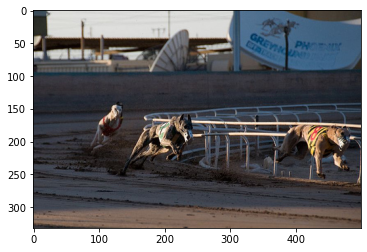

In [104]:
# Using Greedy Search
test_img = img_path_test[6]
captions = greedy_search_evaluate(test_img)[0]
print(captions)
img = plt.imread(test_img)
plt.imshow(img)

###### **Visualize attention**

In [105]:
from PIL import Image
def plot_attention(caption, weights, image_path):
    fig = plt.figure(figsize=(10,10))
    len_caption = len(caption)

    for i in range(len_caption):
        weights_img = np.reshape(weights[i], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))
        ax = fig.add_subplot(len_caption//2, len_caption//2, i+1)
        ax.set_title(caption[i])
        img = ax.imshow(np.array(Image.open(image_path)))
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent = img.get_extent())
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [106]:
from nltk.translate.bleu_score import sentence_bleu

In [107]:
def filtet_text(text):
    filters = ['<start>', '<unk>', '<end>']
    text_split = text.split()
    [text_split.remove(j) for k in filters for j in text_split if j == k]
    text_join = ' '.join(text_split)
    return text_join

In [108]:
def test_caption_generation(path_test, cap_test):
    random_id = np.random.randint(0, len(path_test))
    test_img = path_test[random_id] #random test img
    test_caption = ' '.join(tokenizer.index_word[i] for i in cap_test[random_id] if i not in [0])

    pred_caption, attention_plot, predictions = greedy_search_evaluate(test_img)
    actual_caption = filtet_text(test_caption)

    print ('Actual Caption:', actual_caption)
    print ('Prediction Caption:', pred_caption)

    actual_caption_words = actual_caption.split()
    pred_caption_words = pred_caption.split()

    score1 = sentence_bleu(actual_caption_words,pred_caption_words, weights=(1,0,0,0))
    score2 = sentence_bleu(actual_caption_words,pred_caption_words, weights=(0,1,0,0))
    score3 = sentence_bleu(actual_caption_words,pred_caption_words, weights=(0,0,1,0))
    score4 = sentence_bleu(actual_caption_words,pred_caption_words, weights=(0,0,0,1))
  
    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")
    plot_attention(pred_caption_words, attention_plot, test_img)
    Image.open(test_img)

decoder_ip Shape (1, 1)
Actual Caption: a person is skiing and doing a flip in the snow
Prediction Caption: a skier going down a blue sky

BELU score: 
Individual 1-gram: 14.285714285714285
Individual 2-gram: 2.2250738585072627e-306
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


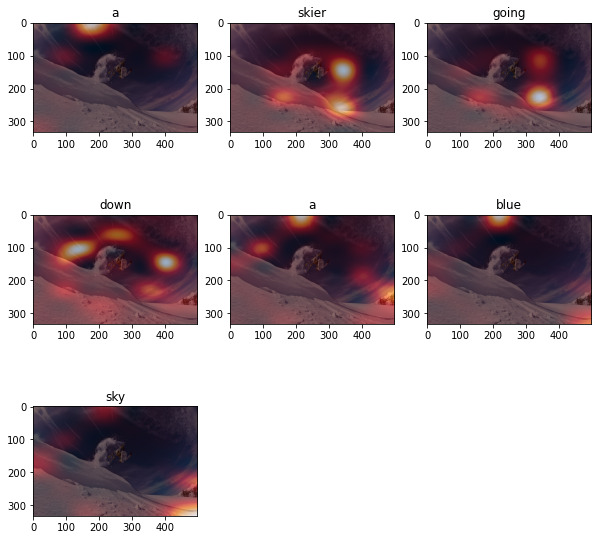

In [109]:
test_caption_generation(img_path_test,cap_test)

###### **Predict caption**

In [110]:
def predict_caption(img_path):
    pred_caption, attention_plot, predictions = greedy_search_evaluate(test_img)
    print ('Prediction Caption:', pred_caption)
    
    plt.imshow(preprocess_img(img_path)[0])
    return pred_caption
    

###### **Predict caption for unknown img**

decoder_ip Shape (1, 1)
Prediction Caption: a crowd of a group of six races around a turn on a racetrack


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


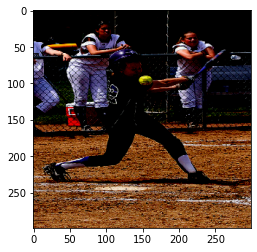

In [114]:
img_path  = img_path_test[5]
pred_caption = predict_caption(img_path)

###### **Covert text to audio**

In [83]:
from gtts import gTTS
from IPython import display 

In [115]:
audio_file = 'pred_caption.mp3'
tts = gTTS(pred_caption, slow=False)
tts.save(audio_file)
display.display(display.Audio(audio_file))